<a href="https://colab.research.google.com/github/rubythalib33/Sekolah-AI-Indonesia/blob/main/Course%201.%20Pytorch%2BLightning%20Coureses%20Level%201/1_6_Captcha_Recognition_using_CNN_%2B_RNN_%2B_CTCLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.6 Captcha Recognition using CNN + RNN + CTCLoss

In [1]:
!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
!unzip -qq captcha_images_v2.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   159  100   159    0     0    420      0 --:--:-- --:--:-- --:--:--   419
100 8863k  100 8863k    0     0  14.4M      0 --:--:-- --:--:-- --:--:-- 14.4M
replace captcha_images_v2/ydd3g.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace captcha_images_v2/36nx4.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace captcha_images_v2/3bnyf.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: no All
replace captcha_images_v2/8y6b3.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: All


In [2]:
!pip install pytorch_lightning

## Config

In [3]:
DATA_DIR = "captcha_images_v2/"
BATCH_SIZE = 8
IMAGE_WIDTH = 300
IMAGE_HEIGHT = 75
NUM_WORKERS = 8
EPOCHS = 200
DEVICE = "cuda"

## Datasets

In [4]:
import albumentations as A
import torch
import numpy as np

import torch.nn as nn
import pytorch_lightning as pl

import glob
import os
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics

from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
class Datasets:
  def __init__(self, image_paths, targets, resize=None):
    self.image_paths = image_paths
    self.targets = targets
    self.resize = resize
    self.aug = A.Compose([A.Normalize(always_apply=True),])
  
  def __len__(self):
    return len(self.image_paths)
  
  def __getitem__(self, item):
    image = Image.open(self.image_paths[item]).convert("RGB")
    targets = self.targets[item]
    if self.resize is not None:
      image = image.resize((self.resize[1], self.resize[0]), resample=Image.BILINEAR)
    image = np.array(image)
    augmented = self.aug(image=image)
    image = augmented["image"]
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    return torch.tensor(image, dtype=torch.float), torch.tensor(targets, dtype=torch.long)

In [6]:
image_files = glob.glob(os.path.join(DATA_DIR, "*.png"))
targets_orig = [x.split("/")[-1][:-4] for x in image_files]
targets = [[c for c in x] for x in targets_orig]

In [7]:
targets_flat = [c for clist in targets for c in clist]

In [8]:
lbl_enc = preprocessing.LabelEncoder()
lbl_enc.fit(targets_flat)
targets_enc = [lbl_enc.transform(x) for x in targets]
targets_enc = np.array(targets_enc) + 1

print(targets)
print(np.unique(targets_flat))
print(len(lbl_enc.classes_))

[['e', 'n', '4', 'n', '4'], ['e', '7', '2', 'c', 'd'], ['e', '8', '4', 'n', '2'], ['6', 'x', 'e', 'n', '4'], ['c', 'c', '8', '4', '5'], ['p', 'c', 'p', 'g', '6'], ['w', '4', 'c', 'n', 'n'], ['4', 'e', 'x', 'n', 'n'], ['5', 'f', '3', 'g', 'f'], ['p', 'c', 'm', '7', 'f'], ['3', '2', 'c', 'n', 'n'], ['x', '3', 'f', 'w', 'f'], ['6', '6', '2', 'b', 'w'], ['x', '5', 'f', '5', '4'], ['m', 'g', 'w', '3', 'n'], ['7', 'b', '4', 'b', 'm'], ['2', '3', 'n', '8', '8'], ['c', 'f', 'c', '2', 'y'], ['2', '6', '4', 'm', '5'], ['m', 'g', 'd', 'w', 'b'], ['7', 'g', 'n', 'g', 'e'], ['f', 'w', 'x', 'd', 'p'], ['b', '4', 'd', '7', 'c'], ['p', '8', 'n', 'g', 'x'], ['5', 'p', '3', 'm', 'm'], ['7', 'd', 'y', 'w', 'w'], ['w', 'd', '2', 'g', 'b'], ['p', 'd', 'c', 'p', '4'], ['c', '4', 'b', 'g', 'd'], ['8', 'p', 'f', 'x', 'x'], ['g', 'c', '8', '3', 'b'], ['y', 'c', 'm', 'c', 'w'], ['x', '5', 'n', 'y', 'n'], ['5', 'x', '5', 'n', 'x'], ['n', '8', 'f', 'p', '6'], ['c', 'p', 'e', '6', '3'], ['n', 'x', 'c', '8', '3'], 

In [9]:
train_imgs, test_imgs, train_targets, test_targets, train_orig_targets, test_orig_targets = model_selection.train_test_split(image_files, targets_enc, targets_orig, test_size=0.1, random_state=42)

In [10]:
train_datasets = Datasets(image_paths=train_imgs, targets=train_targets, resize=(IMAGE_HEIGHT, IMAGE_WIDTH))
test_datasets = Datasets(image_paths=test_imgs, targets=test_targets, resize=(IMAGE_HEIGHT, IMAGE_WIDTH))

In [11]:
train_loader = torch.utils.data.DataLoader(
    train_datasets,
    batch_size = BATCH_SIZE,
    num_workers= NUM_WORKERS,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_datasets,
    batch_size = BATCH_SIZE,
    num_workers= NUM_WORKERS,
    shuffle=False
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [12]:
import matplotlib.pyplot as plt
example=100

In [13]:
npimg = train_datasets[example][0].numpy()

In [14]:
npimg = np.transpose(npimg, (1,2,0))
npimg.shape

(75, 300, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 5, 15,  4, 12, 10])


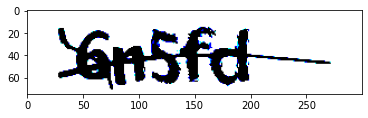

In [15]:
print(train_datasets[example][1])
plt.imshow(npimg*255)

## Model

In [22]:
def decode_prediction(preds, encoder):
  preds = preds.permute(1,0,2)
  preds = torch.softmax(preds, 2)
  preds = torch.argmax(preds, 2)
  preds = preds.detach().cpu().numpy()
  cap_preds = []
  for j in range(preds.shape[0]):
    temp = []
    for k in preds[j,:]:
      k = k - 1
      if k== -1:
        temp.append("[UNK]")
      else:
        temp.append(encoder.inverse_transform([k])[0])
    tp = "".join(temp)
    cap_preds.append(tp)
  return cap_preds

In [17]:
class CaptchaRecognizer(pl.LightningModule):
  def __init__(self, num_chars, batch_size, lr):
    super().__init__()
    self.batch_size = batch_size
    self.lr = lr

    self.conv_1 = nn.Conv2d(3, 128, (3,3), padding=1)
    self.max_pool_1 = nn.MaxPool2d(kernel_size=(2,2))

    self.conv_2 = nn.Conv2d(128, 64, (3,3), padding=1)
    self.max_pool_2 = nn.MaxPool2d(kernel_size=(2,2))

    self.linear_1 = nn.Linear(1152, 64)
    self.dropout = nn.Dropout(0.2)

    self.gru = nn.GRU(64, 32, bidirectional=True, num_layers=2, dropout=0.25)
    
    self.output =  nn.Linear(64, num_chars+1)
  
  def forward(self, x, y=None):
    bs, c, h, w = x.size()
    x = torch.relu(self.conv_1(x))
    x = self.max_pool_1(x)

    x = torch.relu(self.conv_2(x))
    x = self.max_pool_2(x)

    x = x.permute(0, 3, 1, 2)

    x = x.view(bs, x.size(1), -1)

    x = self.linear_1(x)
    x = self.dropout(x)
    x, _ = self.gru(x)

    x = self.output(x)
    x = x.permute(1,0,2)
    if y is not None:
      log_softmax_values = torch.log_softmax(x, 2)
      input_length = torch.full(
          size = (bs, ), fill_value = log_softmax_values.size(0), dtype=torch.int32
      )
      # print(input_length)
      target_length = torch.full(
          size = (bs, ), fill_value = y.size(1), dtype=torch.int32
      )
      # print(target_length)
      loss = nn.CTCLoss(blank=0)(log_softmax_values, y, input_length, target_length)
      return x, loss
    
    return x, None

  def training_step(self, batch, batch_bn):
    X,y = batch
    # print(X,y)
    _, loss = self(X, y)
    return loss
  def validation_step(self, batch, batch_bn):
    x, y = batch
    pred, loss = self(x, y)
    return loss
  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=self.lr)

In [18]:
cm = CaptchaRecognizer(19, BATCH_SIZE, 1e-3)
img = torch.rand(5, 3, 75, 300)
target = torch.randint(0,20,(5,5))
x, loss = cm(img, target)
print(x.shape)

torch.Size([75, 5, 20])


In [19]:
#make the auto_scale_batch_size to true
trainer = pl.Trainer(auto_scale_batch_size=True, auto_lr_find = True, gpus=1, max_epochs=EPOCHS, progress_bar_refresh_rate=20)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [20]:
trainer.fit(cm, train_loader, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | conv_1     | Conv2d    | 3.6 K 
1 | max_pool_1 | MaxPool2d | 0     
2 | conv_2     | Conv2d    | 73.8 K
3 | max_pool_2 | MaxPool2d | 0     
4 | linear_1   | Linear    | 73.8 K
5 | dropout    | Dropout   | 0     
6 | gru        | GRU       | 37.6 K
7 | output     | Linear    | 1.3 K 
-----------------------------------------
190 K     Trainable params
0         Non-trainable params
190 K     Total params
0.760     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Result on test data

In [23]:
from pprint import pprint
valid_preds = []

for img, target in test_loader:
  preds,_ = cm(img)
  result = decode_prediction(preds, lbl_enc)
  valid_preds.extend(result)

pprint(list(zip(test_orig_targets, valid_preds)))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[('dce8y',
  '[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]d[UNK][UNK][UNK]c[UNK][UNK][UNK][UNK][UNK][UNK]ee[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]8[UNK][UNK][UNK][UNK]y[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]'),
 ('g247w',
  '[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]g[UNK][UNK][UNK][UNK][UNK][UNK]22[UNK][UNK][UNK][UNK][UNK]4[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]7[UNK][UNK][UNK][UNK][UNK][UNK]w[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]'),
 ('7xd5m',
  '[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]7[UNK][UNK][UNK][UNK][UNK]x[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]dd[UNK][UNK]5[UNK][UNK][UNK][UNK][UNK][UNK]m[UNK][UNK]m[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][